In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1)

In [23]:
def f(x):
    return x * np.sin(x)

X = np.atleast_2d(np.random.uniform(0, 10.0, size=1000)).T
X = X.astype(np.float32)

y = f(X).ravel()
y += np.random.randn(len(y))
y = y.astype(np.float32)

xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
xx = xx.astype(np.float32)

In [24]:
def plot(y_pred, y_upper, y_lower):
    fig = plt.figure()
    plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
    plt.plot(X, y, 'g.', markersize=5, label=u'Observations', alpha=0.5)
    plt.plot(xx, y_pred, 'r-', label=u'Prediction')
    plt.plot(xx, y_upper, 'b-')
    plt.plot(xx, y_lower, 'b-')
    plt.fill(np.concatenate([xx, xx[::-1]]),
             np.concatenate([y_upper, y_lower[::-1]]),
             alpha=.1, fc='b', ec='None')
    plt.ylim(-10, 10)
    plt.show()

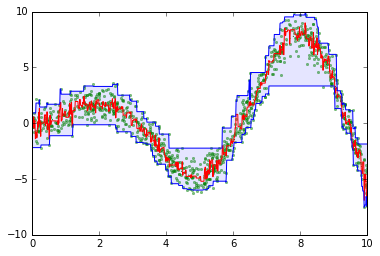

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

alpha = 0.025
r = GradientBoostingRegressor(loss='quantile', alpha=alpha,
                              n_estimators=250, max_leaf_nodes=10)

r.set_params(alpha=alpha)
r.fit(X, y)
y_upper = r.predict(xx)

r.set_params(alpha=1.0 - alpha)
r.fit(X, y)
y_lower = r.predict(xx)

r.set_params(loss='ls')
r.fit(X, y)
y_pred = r.predict(xx)

plot(y_pred, y_upper, y_lower)

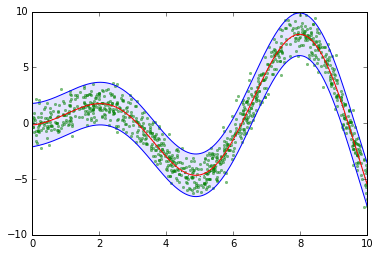

In [26]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

r = GaussianProcessRegressor(kernel=1.0 * RBF() + WhiteKernel())
r.fit(X, y)
y_pred, std = r.predict(xx, return_std=True)

plot(y_pred, y_pred+1.96*std, y_pred-1.96*std)

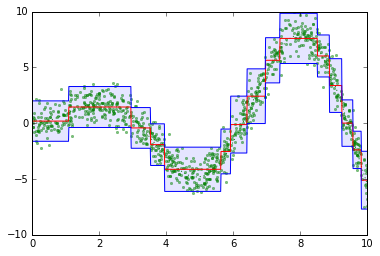

In [27]:
from skopt.learning import DecisionTreeRegressor

r = DecisionTreeRegressor(max_leaf_nodes=15)
r.fit(X, y)
y_pred, std = r.predict(xx, return_std=True)

plot(y_pred, y_pred+1.96*std, y_pred-1.96*std)

In [28]:
# Variance = variance of all training samples belonging to the same nodes

from sklearn.ensemble.forest import _generate_sample_indices

def weighted_std(values, weights):
    average = np.average(values, weights=weights)
    variance = np.average((values - average) ** 2, weights=weights)  
    return variance ** 0.5


def std_v1(forest, X_train, y_train, X_test):
    # Map tree_id, node_id to list of training samples
    mapping = {}
    
    for t, tree in enumerate(forest.estimators_):
        if forest.bootstrap:
            indices = _generate_sample_indices(tree.random_state, len(X_train))
        else:
            indices = np.arange(len(X_train)).astype(int)
            
        for i, node in zip(indices, tree.apply(X_train[indices])):
            if t not in mapping:
                mapping[t] = {}
                
            if node not in mapping[t]:
                mapping[t][node] = []
                
            mapping[t][node].append(i)
   
    # Gather training samples
    std = np.zeros(len(X_test))
    
    for i, leaves in enumerate(forest.apply(X_test)):
        neighborhood = []
        weights = []
        
        for t, node in enumerate(leaves):
            neighborhood.extend(mapping[t][node])
            weights.extend([1. / len(mapping[t][node])] * len(mapping[t][node]))
            
        std[i] = weighted_std([y_train[j] for j in neighborhood], weights)
        
    return std

In [29]:
# Variance = variance of tree predictions

def std_v2(forest, X_test):    
    p = [tree.predict(X_test) for tree in forest.estimators_]
    std = np.std(p, axis=0)
    return std

In [30]:
# Variance = SMAC 4.3.2 of http://arxiv.org/abs/1211.0906

def std_v3(forest, X_train, y_train, X_test):         
    std = np.zeros(len(X_test))
    mu = forest.predict(X_test)

    for t, tree in enumerate(forest.estimators_):
        var_b = tree.tree_.impurity[tree.apply(X_test)] 
        mu_b = tree.predict(X_test)
        std += var_b + mu_b ** 2
        
    std /= len(forest.estimators_)
    std -= mu ** 2
    
    return std ** 0.5

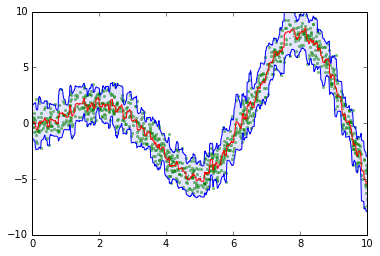

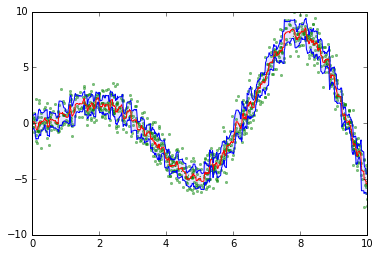

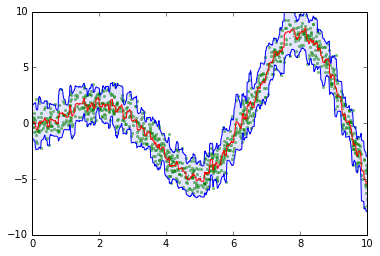

In [31]:
from sklearn.ensemble import RandomForestRegressor

r = RandomForestRegressor(n_estimators=500, min_samples_leaf=5)
r.fit(X, y)

y_pred = r.predict(xx)
std = std_v1(r, X, y, xx)
plot(y_pred, y_pred+1.96*std, y_pred-1.96*std)

y_pred = r.predict(xx)
std = std_v2(r, xx)
plot(y_pred, y_pred+1.96*std, y_pred-1.96*std)

y_pred = r.predict(xx)
std = std_v3(r, X, y, xx)
plot(y_pred, y_pred+1.96*std, y_pred-1.96*std)

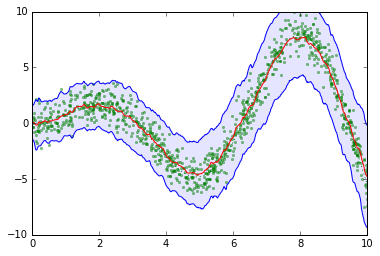

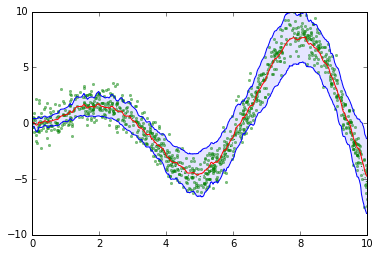

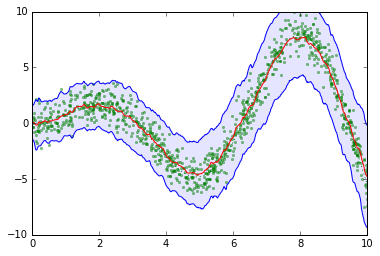

In [32]:
from sklearn.ensemble import ExtraTreesRegressor

r = ExtraTreesRegressor(n_estimators=500, min_samples_leaf=5)
r.fit(X, y)

y_pred = r.predict(xx)
std = std_v1(r, X, y, xx)
plot(y_pred, y_pred+1.96*std, y_pred-1.96*std)

y_pred = r.predict(xx)
std = std_v2(r, xx)
plot(y_pred, y_pred+1.96*std, y_pred-1.96*std)

y_pred = r.predict(xx)
std = std_v3(r, X, y, xx)
plot(y_pred, y_pred+1.96*std, y_pred-1.96*std)